# PaperCompanion1_I - Stochastic Learning
Notebook to generate the first part of figure 1 of the paper, depicting the stochastic runs of the algorithm. 
It depicts the learning dynamics in Q-space and policy-space against time steps played.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
# import own classes
from agent_game_sim import QLearningAgent
from agent_game_sim import Game
from agent_game_sim import Simulation
# import own functions
from agent_game_sim import reward_matrix_for_two_player_PD
from agent_game_sim import generate_q_values

# set the random seed to fix the random number generator. To reproduce the results in the paper, load the data files.
np.random.seed(42)

In [2]:
# game parameters
num_players = 2
action_space = np.array([0 ,  1], dtype=float) # (0 = cooperate, 1 = defect)
observation_length = 0 # number of previous actions that are considered in the observation vector. In this paper, agents cannot observe joint actions of previous rounds! (0 = only current action)
use_prefactor = False # if True, the reward is scaled by the prefactor (1 - discount_factor)

# define the agents
agent_pair = [QLearningAgent, QLearningAgent]
discount_factor = 0.8
learning_rate = 0.01
selection_method = "Boltzmann" 
temperature = 1
initial_probability_pair = (0.5, 0.48)
base_value = 0
initial_q_tables = [generate_q_values(prob, temperature, base_value) for prob in initial_probability_pair]
initial_q_tables = [np.expand_dims(q_table, axis=0) for q_table in initial_q_tables] # Add a zero dimension to the Q-table, indexing the state. Irrelevant for single state games (independent Q-learning with no observation of past actions), but necessary for multi-state games.
print("Initial Q-table of first agent: ", initial_q_tables[0])
print("Initial Q-table of second agent: ", initial_q_tables[1])

# Create a list of agents
agents = [agent_pair[i](player_id = i, 
                action_space = action_space,
                num_players = num_players,
                discount_factor = discount_factor,
                observation_length = observation_length,
                selection_method = selection_method,
                reward_func = reward_matrix_for_two_player_PD,
                temperature = temperature,
                learning_rate = learning_rate,
                q_table = initial_q_tables[i],
                use_prefactor = use_prefactor
                )       
                for i in range(num_players)]

# Create a game and a Simulation
game = Game(agents = agents)
simulation = Simulation()

# set the length of the episode. This is the number of time steps for which the learning process runs. 
if discount_factor == 0.: # if discount factor is 0, 3e3 time steps are enough
    num_time_steps = int(3e3)
    axis_resolution = 1 # 
elif discount_factor == 0.8: # if discount factor is 0.8, 1e5 time steps are necessary
    num_time_steps = int(1e5)
    axis_resolution = 0
elif discount_factor == 0.8 and initial_probability_pair == (0.9, 0.7):
    num_time_steps = int(2.1e6) # for the special case of probability trajectories starting at (0.9, 0.7), 2.1e6 time steps are necessary
    axis_resolution = 0
else:
    num_time_steps = int(1e2) # set default value
    axis_resolution = 1

Initial Q-table of first agent:  [[0. 0.]]
Initial Q-table of second agent:  [[-0.04002135  0.04002135]]


Either load the data from the data directory with the specified parameters or run the learning process to generate new data. To store newly generated data, set store_data to `True`. BEWARE: this will overwrite existing files!
To reproduce the exact plots from the paper, load the data files with the corresponding parameters.

In [3]:
# Either run the learning process to generate new data or load the data from the data directory with the specified parameters.
load_data = True # if True, run the simulation to generate new data. Else, load the data from the data directory below by setting load_data to True
directory_for_data = os.path.join("data", "TimeEvolution") # directory for saving the data
if not os.path.exists(directory_for_data):
    os.makedirs(directory_for_data)

# load the Q_table histories and the probabilities from files if you want to reproduce results. 
if load_data:
    q_table_histories = np.load( os.path.join(directory_for_data, f"Q_table_histories_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), allow_pickle=True)
    probabilities_agents = np.load( os.path.join(directory_for_data, f"probabilities_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), allow_pickle=True)
    for i, agent in enumerate(agents):
        agent.q_table_history = q_table_histories[i] 

# else, run the simulation to generate new data
if load_data == False:
    # run the simulation and collect the probabilities of cooperation for each agent in the list probabilities_agents
    simulation.run(game, agents, num_time_steps)
    probabilities_agents = [] # first index: agent, second index: time step
    # Extract the probabilities of cooperation for each time step for each agent and append them to the list
    for agent in agents:
        prob_to_coop = np.array([agent.get_action_probabilities(q_table) for q_table in agent.q_table_history[:]])[:, 0, 0] # Extract the first entry of each 2D array
        probabilities_agents.append(prob_to_coop)

    # If set to True, store the Q-table histories and the probabilities in the data directory to make the results reproducible. BEWARE: this will overwrite the existing files!
    store_data = False 
    if store_data:
        np.save(os.path.join(directory_for_data, f"Q_table_histories_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), [agent.q_table_history for agent in agents])
        np.save(os.path.join(directory_for_data, f"probabilities_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), probabilities_agents)

# print shape of the Q-table histories and the probabilities
print("Shape of Q-table histories: ", [agent.q_table_history.shape for agent in agents])
print("Shape of probabilities_agents: ", np.shape(probabilities_agents))

Shape of Q-table histories:  [(100001, 1, 2), (100001, 1, 2)]
Shape of probabilities_agents:  (2, 100001)


/var/folders/m0/6bzh86rj63g58k6l_qqv_3z80000gn/T/ipykernel_68322/2126405226.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


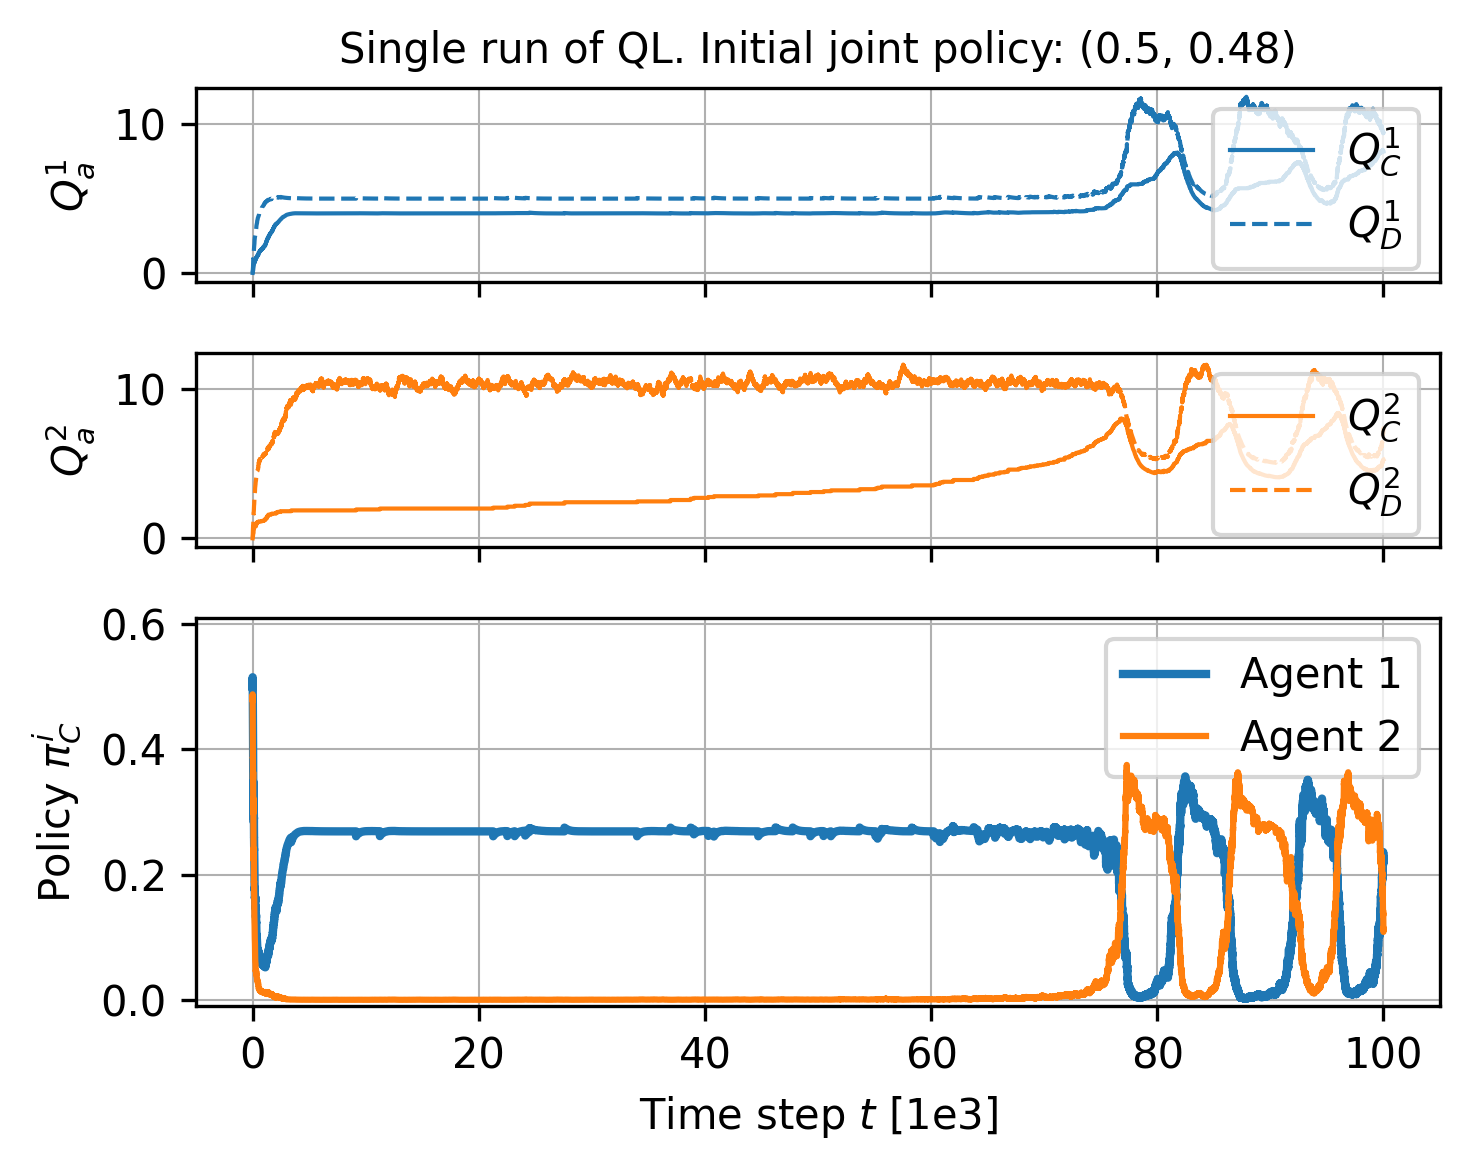

In [4]:
# Plotting parameters
directory_for_figures = 'PaperFigures' # directory for saving the figures
if not os.path.exists(directory_for_figures):
    os.makedirs(directory_for_figures)
figsize=(5, 4)
fontsize = None
dpi=300 # dpi for saving the figure
color1 = 'C0' # color blue for the first agent
color2 = 'C1' # color orange for the second agent
color_array = [color1, color2]

# Figure to compare the Q-values and the probabilities over time
fig, ax = plt.subplots(3, 1, figsize=figsize, dpi=dpi, sharex=True, gridspec_kw={'height_ratios': [1, 1, 2]})
# change the location of the legend in plots for the (0.9, 0.7) case where gamma = 0.8
if initial_probability_pair == (0.9, 0.7) and discount_factor == 0.8:
    loc="center"
else: 
    loc="upper right"

# set the maximum number of time steps for plotting. Need to be adjusted for the data loaded for initial_probability_pair = (0.9, 0.7) and discount_factor = 0.8, because the data contains more time steps than needed for the plot.
if load_data and initial_probability_pair == (0.9, 0.7) and discount_factor == 0.8:
    max_time_steps = int(2.1e6)
else:
    max_time_steps = len(probabilities_agents[0]) - 1 # -1 because the first entry is the initial probability

# FIGURE A: plot Q-values over time
for i, agent in enumerate(agents):
    q_values_C = [q_table[0, 0] for q_table in agent.q_table_history[:max_time_steps]]
    q_values_D = [q_table[0, 1] for q_table in agent.q_table_history[:max_time_steps]]
    ax[i].plot(q_values_C, label=f'$Q^{i+1}_C$', color=color_array[i], linestyle='-', linewidth=1)
    ax[i].plot(q_values_D, label=f'$Q^{i+1}_D$', color=color_array[i], linestyle='--', linewidth=1)
    ax[i].set_ylabel(f'$Q^{i+1}'+r'_{a}$', fontsize=fontsize)
    #ax[i].set_ylim(-1.5, 1.5)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i].grid(linestyle='-', linewidth=0.5)
    ax[i].legend(loc=loc, fontsize=fontsize)

# identify which range is larger for the Q-value plots
y_range_0 = ax[0].get_ylim()
y_range_1 = ax[1].get_ylim()
# get the minimum and the maximum
y_range = [min(y_range_0[0], y_range_1[0]), max(y_range_0[1], y_range_1[1])]
for i in range(2):
    ax[i].set_ylim(y_range)

# FIGURE B: plot probabilities over time
handle1 = ax[2].plot(probabilities_agents[0][:max_time_steps], label=f'Agent 1', color=color1, linewidth=2, zorder=10)
handle2 = ax[2].plot(probabilities_agents[1][:max_time_steps], label=f'Agent 2', color=color2, zorder=10)
ax[0].set_title(f'Single run of QL. Initial joint policy: {initial_probability_pair}', fontsize=fontsize) # title

# Define a custom formatter to scale the x-axis labels by 1e3
def scientific_formatter(x, pos):
    return f'{x / 1e3:.{axis_resolution}f}'
# Set the custom formatter for the x-axis
ax[2].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
# set labels
ax[2].set_xlabel('Time step $t$ [1e3]', fontsize=fontsize)
ax[2].set_ylabel(f'Policy $\pi^i_C$', fontsize=fontsize)
ax[2].legend(loc=loc, fontsize=fontsize, ncol=1)
ax[2].grid(linestyle='-', linewidth=0.5)

# fix the y-axis of the probability plot to the range
if initial_probability_pair == (0.5, 0.5) or initial_probability_pair == (0.5, 0.48):
    ax[2].set_ylim(-0.01, 0.61)
else:
    ax[2].set_ylim(-0.01, 1.1)
    ax[2].set_yticks(np.arange(0, 1.2, 0.2))

# save the figure in the directory for figures
fig.tight_layout()
fig.savefig(os.path.join(directory_for_figures, f'Fig1_SIMULATION_TimeEvolution_p_initial_{initial_probability_pair}_y={discount_factor}_T={temperature}_alpha={learning_rate}_time={num_time_steps}.pdf'), dpi=dpi, bbox_inches='tight')
fig.show()

For a discount factor of 0.8 and initial probabilities (0.9, 0.7), we generate a plot where the x-axis is split in two, to better capture the time dynamics at the beginning and at the end of the learning process. To reproduce the results displayed in the paper, load the data.

y_range: [np.float64(-2.0986122886681096), np.float64(23.94941957731441)]


/var/folders/m0/6bzh86rj63g58k6l_qqv_3z80000gn/T/ipykernel_68322/2102876826.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


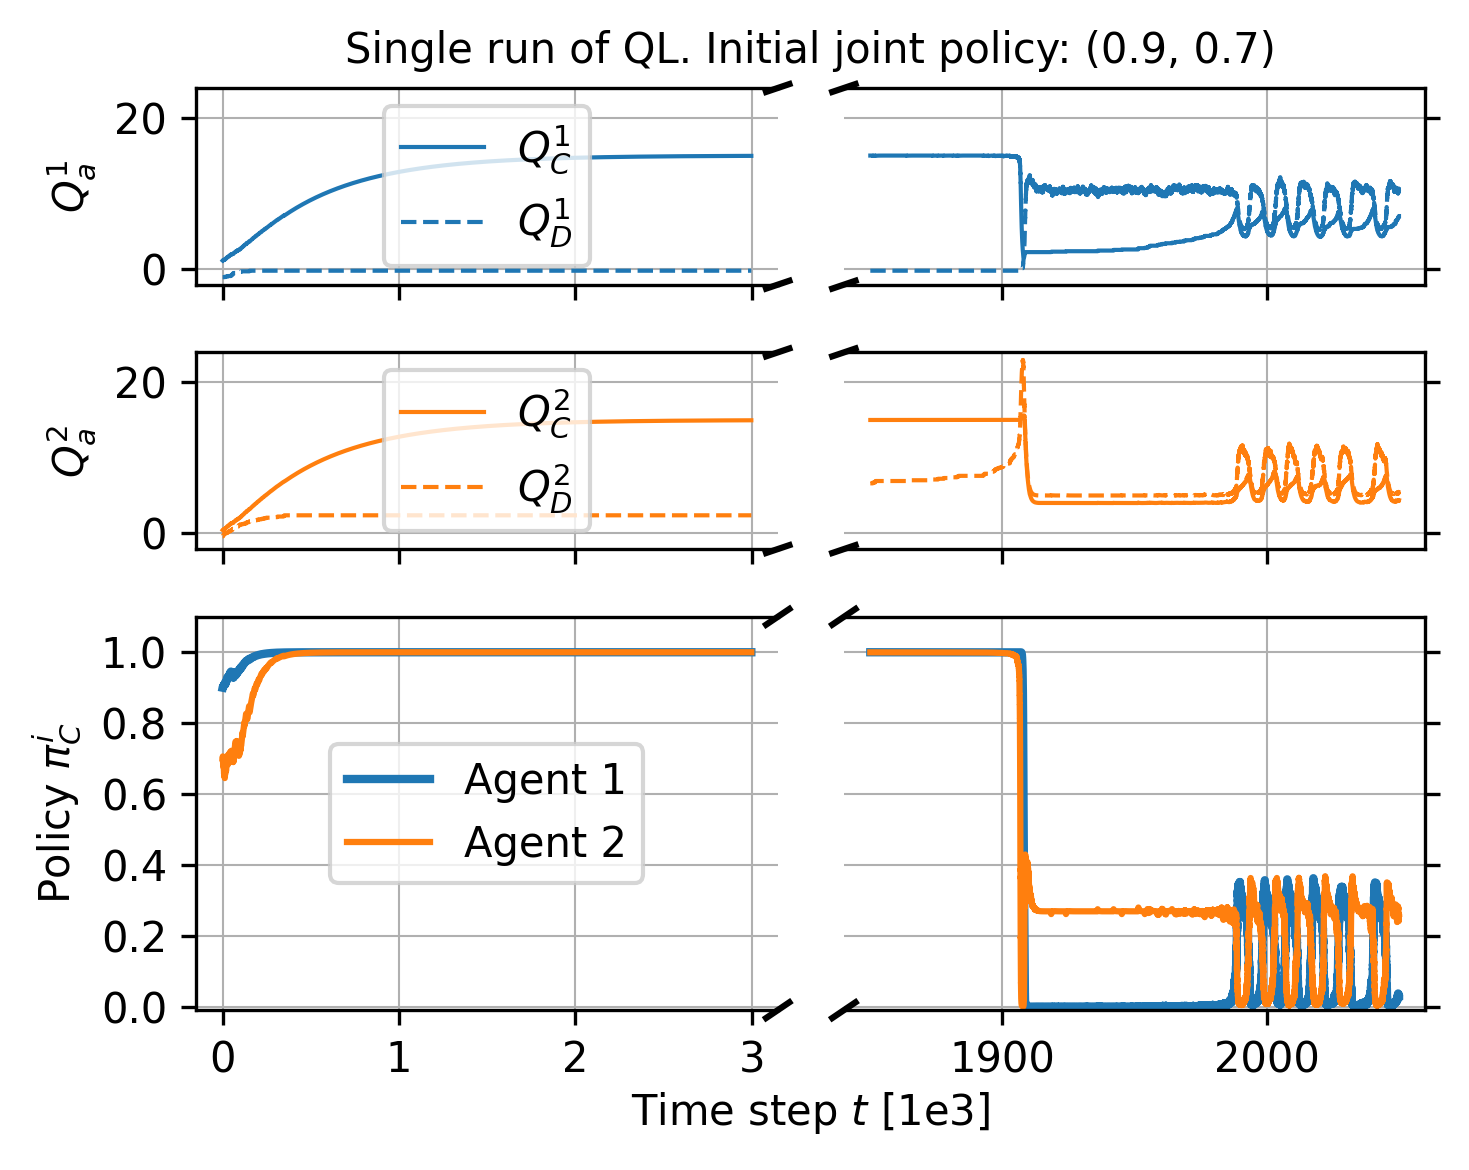

In [5]:
fig, ax = plt.subplots(3, 2, figsize=figsize, dpi=dpi, gridspec_kw={'height_ratios': [1, 1, 2]}, sharex='col', sharey='row')

# load the Q_table histories and the probabilities from files
initial_probability_pair = (0.9, 0.7)
temperature = 1
learning_rate = 0.01
discount_factor = 0.8

# load the Q_table histories and the probabilities from the data directory
q_table_histories = np.load( os.path.join(directory_for_data, f"Q_table_histories_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), allow_pickle=True)
probabilities_agents = np.load( os.path.join(directory_for_data, f"probabilities_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), allow_pickle=True)
for i, agent in enumerate(agents):
    agent.q_table_history = q_table_histories[i] 

max_time_steps = int(2.05e6) # The data contains more time steps than needed for the plot. Set the maximum number of time steps for plotting.
x_range_1 = np.arange(0, int(3e3)-1)
x_range_2 = np.arange(int(1.85e6), max_time_steps)
loc="center" 

# LEFT SIDE: first range
# FIGURE A: plot Q-values over time
for i, agent in enumerate(agents):
    q_values_C_range_1 = [q_table[0, 0] for q_table in agent.q_table_history[x_range_1]]
    q_values_D_range_1 = [q_table[0, 1] for q_table in agent.q_table_history[x_range_1]]
    ax[i][0].plot(x_range_1, q_values_C_range_1, label=f'$Q^{i+1}_C$', color=color_array[i], linestyle='-', linewidth=1)
    ax[i][0].plot(x_range_1, q_values_D_range_1, label=f'$Q^{i+1}_D$', color=color_array[i], linestyle='--', linewidth=1)
    ax[i][0].set_ylabel(f'$Q^{i+1}'+r'_{a}$', fontsize=fontsize)
    ax[i][0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i][0].grid(linestyle='-', linewidth=0.5)
    ax[i][0].legend(loc=loc, fontsize=fontsize)

# calculate the range of the y-axis
y_range = [np.min(q_table_histories)-1, np.max(q_table_histories)+1]
print("y_range:" , y_range)
for i in range(2):
    ax[i][0].set_ylim(y_range)

# FIGURE B: plot probabilities over time
handle1 = ax[2][0].plot(x_range_1, probabilities_agents[0][x_range_1], label=f'Agent 1', color=color1, zorder=10, linewidth=2)
handle2 = ax[2][0].plot(x_range_1, probabilities_agents[1][x_range_1], label=f'Agent 2', color=color2, zorder=10, linestyle='-')
ax[2][0].set_ylabel(f'Policy $\pi^i_C$', fontsize=fontsize)
# fix the y-axis to the range [-0.01, 1.1]
ax[2][0].set_ylim(-0.01, 1.1)
# Define a custom formatter to scale the x-axis labels by 1e3
def scientific_formatter(x, pos):
    return f'{x / 1e3:.0f}'
# Set the custom formatter for the x-axis
ax[2][0].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
# set the ticks of the y-axis to be in steps of 0.2
ax[2][0].set_yticks(np.arange(0, 1.2, 0.2))
ax[2][0].legend(loc=loc, fontsize=fontsize)
ax[2][0].grid(linestyle='-', linewidth=0.5)

# RIGHT SIDE: second range
# FIGURE A: plot Q-values over time
for i, agent in enumerate(agents):
    q_values_C_range_2 = [q_table[0, 0] for q_table in agent.q_table_history[x_range_2]]
    q_values_D_range_2 = [q_table[0, 1] for q_table in agent.q_table_history[x_range_2]]
    ax[i][1].plot(x_range_2, q_values_C_range_2, label=f'$Q^{i+1}_C$', color=color_array[i], linestyle='-', linewidth=1)
    ax[i][1].plot(x_range_2, q_values_D_range_2, label=f'$Q^{i+1}_D$', color=color_array[i], linestyle='--', linewidth=1)
    #ax[i][1].set_ylabel(f'$Q^{i+1}'+r'_{a}$', fontsize=fontsize)
    ax[i][1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i][1].grid(linestyle='-', linewidth=0.5)
# ensure that the y-axis is the same as on the left side
ax[0][1].set_ylim(y_range)
ax[1][1].set_ylim(y_range)

# FIGURE B: plot probabilities over time
ax[2][1].plot(x_range_2, probabilities_agents[0][x_range_2], color=color1, linewidth=2)
ax[2][1].plot(x_range_2, probabilities_agents[1][x_range_2], color=color2, linestyle='-')
# set labels
ax[2][1].set_xlabel(' ', fontsize=fontsize)
# fix the y-axis to the range [-0.01, 1.1]
ax[2][1].set_ylim(-0.01, 1.1)
# Set the custom formatter for the x-axis
ax[2][1].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
ax[2][1].grid(linestyle='-', linewidth=0.5)

for i in range(3):
    # Hide the spines between the subplots
    ax[i][0].spines['right'].set_visible(False)
    ax[i][1].spines['left'].set_visible(False)
    ax[i][0].yaxis.tick_left()
    ax[i][1].yaxis.tick_right()

    # Add diagonal lines to indicate the break
    d = .02  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax[i][0].transAxes, color='k', clip_on=False)
    ax[i][0].plot((1-d, 1+d), (-d, +d), **kwargs)
    ax[i][0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    kwargs.update(transform=ax[i][1].transAxes)  # switch to the right axes
    ax[i][1].plot((-d, +d), (-d, +d), **kwargs)
    ax[i][1].plot((-d, +d), (1-d, 1+d), **kwargs)

# Add a common x-axis label
fig.text(0.55, 0.05, 'Time step $t$ [1e3]', ha='center')

# title
ax[0][0].set_title(f' ', fontsize=fontsize)
fig.text(0.55, 0.935, f'Single run of QL. Initial joint policy: {initial_probability_pair}', fontsize=fontsize, ha='center')

# save the figure
fig.tight_layout()
fig.savefig(os.path.join(directory_for_figures, f'Fig1_SIMULATION_TimeEvolution_p_initial_{initial_probability_pair}_y={discount_factor}_T={temperature}_alpha={learning_rate}_time={num_time_steps}.pdf'), dpi=dpi, bbox_inches='tight')
fig.show()